First we load `rpy2.ipython` extension so we can execute `R` code.

In [137]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Load up the Hadleyverse

In [138]:
%%R
suppressMessages({
library(dplyr)
library(tidyr)
library(ggplot2)
})

# Exposure Logs
First we logged everytime a user loaded up the user interface. Often we want to only take the first exposure by a user.

In [152]:
%%R
src2ideology <- c(
    'foxnews' = -1,
    'cnn' = 0,
    'msnbc' = 1
)

Exp <- read.csv('data/exposure_log.csv', stringsAsFactors = FALSE) %>%
    group_by(userid, story_key) %>%
    arrange(time) %>%
    summarise(source = first(source), position = first(position)) %>%
    mutate(source.ideology = src2ideology[source]) %>%
    ungroup

cat('We have', nrow(Exp), 'exposures.', '\n')
cat('We have', with(Exp, length(unique(userid))), 'potential subjects.', '\n\n')
head(Exp)

We have 3415 exposures. 
We have 343 potential subjects. 

Source: local data frame [6 x 5]

  userid story_key source position source.ideology
1     56         0  msnbc        8               1
2     56         1    cnn        6               0
3     56         2  msnbc        4               1
4     56         3  msnbc        2               1
5     56         4    cnn        1               0
6     56         5    cnn        5               0


# Events Logs

The events log is produced by user actions that take place sometime after the exposure. So in this experiment we logged two kinds of these:  summaries and survey responses.

In [155]:
%%R
Sum <- read.csv('data/summary_log.csv', stringsAsFactors = FALSE) %>%
    group_by(userid, story_key) %>%
    arrange(time) %>%
    summarise(summary = first(summary)) %>%
    ungroup

cat('We have', nrow(Sum), 'summaries.', '\n')
cat('We have', with(Sum, length(unique(userid))), 'subjects who wrote summaries.', '\n')
cat(with(Sum, round(mean(summary), 2)), 'stories were summarized.', '\n\n')
head(Sum)

We have 505 summaries. 
We have 51 subjects who wrote summaries. 
0.25 stories were summarized. 

Source: local data frame [6 x 3]

  userid story_key summary
1   3376         0       1
2   3376         1       1
3   3376         2       1
4   3376         3       1
5   3376         4       1
6   3376         5       1


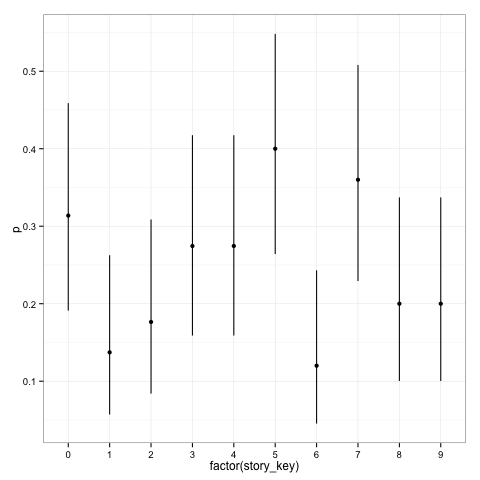

In [158]:
%%R
Sum %>%
  group_by(story_key) %>%
  summarise(k = sum(summary), n = n(),
            p = mean(summary),
            lcl = binom.test(k, n)$conf.int[1], 
            ucl = binom.test(k, n)$conf.int[2]) %>%
  ggplot(aes(x = factor(story_key), y = p, ymin = lcl, ymax = ucl)) +
  geom_pointrange() +
  theme_bw()

#Survey Responses

In [198]:
%%R
Survey <- read.csv('data/survey_log.csv', stringsAsFactors = FALSE) %>%
  filter(!is.na(response)) %>%
  group_by(userid) %>%
  arrange(time) %>%
  summarise(response = first(response), reversed_scale = first(reversed_scale)) %>%
  # The scale is [0, 4], let's convert it to [-2, 2]
  mutate(subject.ideology = response - 2) %>%
  ungroup

cat('We have ', nrow(Survey), 'survey responses.', '\n')
head(Survey)

We have  44 survey responses. 
Source: local data frame [6 x 4]

  userid response reversed_scale subject.ideology
1   3376        2              0                0
2   7002        1              0               -1
3  10436        2              1                0
4  12743        2              0                0
5  13403        3              1                1
6  15517        3              0                1


#EDA

It's good to do some EDA on your data to make sure that everything looks good.

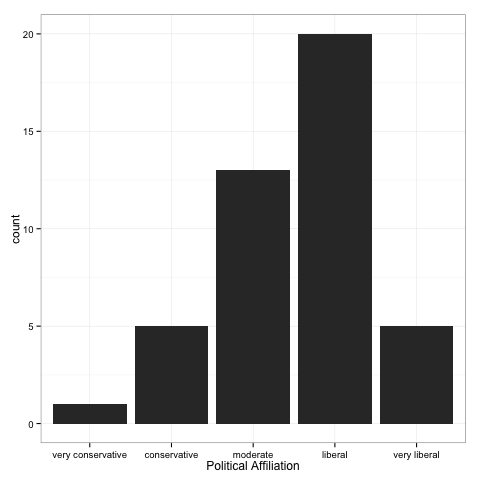

In [143]:
%%R
Survey %>%
  ggplot(aes(x = factor(subject.ideology, labels = c('very conservative', 'conservative', 'moderate', 'liberal', 'very liberal')))) +
  geom_histogram() +
  theme_bw() +
  xlab('Political Affiliation')

# Joining Results

Typically we need to perform joins from the exposures to the outcomes in order to analyze the data.

In [204]:
%%R
Results <- Exp %>% 
  inner_join(Sum, c('userid', 'story_key')) %>%
  inner_join(Survey, 'userid') %>%
  mutate(aligned = factor(sign(subject.ideology) == sign(source.ideology), labels = c('not aligned', 'aligned'))) %>%
  group_by(userid) %>%
  mutate(num_stories = n(), num_summaries = sum(summary))

with(Results %>% filter(subject.ideology != 0), summary(aligned))

not aligned     aligned 
        189         116 


In [207]:
%%R
Results %>%
  group_by(num_stories, num_summaries) %>%
  summarise(n = length(unique(userid)))

Source: local data frame [6 x 3]
Groups: num_stories

  num_stories num_summaries  n
1           5             1  1
2          10             0  3
3          10             1  4
4          10             2  3
5          10             3 31
6          10            10  2


In [197]:
%%R
Results %>%
  group_by(source.ideology) %>%
  summarise(n = n(), num.users = length(unique(userid)))

Source: local data frame [3 x 3]

  source.ideology   n num.users
1              -1 130        44
2               0 130        44
3               1 175        44


Now we can tabulate the selections by source ideology to measure the ATE.

In [211]:
%%R
Results %>%
  group_by(aligned) %>%
  summarise(p.summary = mean(summary),
            measurement = 'p.summary') %>%
  spread(aligned, p.summary) %>%
  mutate(ate = aligned - `not aligned`)

Source: local data frame [1 x 4]

  measurement not aligned   aligned         ate
1   p.summary   0.2964286 0.2645161 -0.03191244


#Modeling the Results
We can also analyze the data pretty easily using a regression.

In [181]:
%%R
m <- lm(summary ~ aligned, data = Results)
summary(m)


Call:
lm(formula = summary ~ aligned, data = Results)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.2964 -0.2964 -0.2645  0.7036  0.7355 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.29643    0.02703  10.968   <2e-16 ***
alignedaligned -0.03191    0.04527  -0.705    0.481    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4522 on 433 degrees of freedom
Multiple R-squared:  0.001146,	Adjusted R-squared:  -0.001161 
F-statistic: 0.4968 on 1 and 433 DF,  p-value: 0.4813

